# CAFA 5 protein function Prediction with TensorFlow

This notebook walks you through how to train a DNN model using TensorFlow on the CAFA 5 protein function Prediction dataset made available for this competition. 

The objective of the model is to predict the function(aka **GO term ID**) of a set of proteins based on their amino acid sequences and other data.


**Note** : This notebook runs without any GPU. This is because enabling GPUs leaves less RAM memory on the VM and the submission step needs a lot of memory. One point where this would impact is when training the model. With CPU it will take around 2 minutes while on GPU it would take around 30 seconds.

## About the Data

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters. 

<img src="https://cityu-bioinformatics.netlify.app/img/tools/protein/pro_seq.png" alt ="Sequence.png" style='width: 800px;' >

Image source - [https://cityu-bioinformatics.netlify.app/](https://cityu-bioinformatics.netlify.app/too2/new_proteo/pro_seq/)

The `train_sequences.fasta` made available for this competitions, contains the sequences for proteins with annotations (labelled proteins).

# Gene Ontology

We can define the functional properties of a proteins using Gene Ontology(GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

Read more about Gene Ontology [here](http://geneontology.org/docs/ontology-documentation).

File `train_terms.tsv` contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears. 

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence. This means that the task at hand is a multi-label classification problem. 

# Protein embeddings for train and test data

To train a machine learning model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly. They have to be converted into a vector format. In this notebook, we will use embeddings of the protein sequences to train the model. You can think of protein embeddings to be similar to word embeddings used to train NLP models.
<!-- Instead, to make calculations and data preparation easier we will use precalculated protein embeddings.
 -->
Protein embeddings are a machine-friendly method of capturing the protein's structural and functional characteristics, mainly through its sequence. One approach is to train a custom ML model to learn the protein embeddings of the protein sequences in the dataset being used in this notebook. Since this dataset represents proteins using amino-acid sequences which is a standard approach, we can use any publicly available pre-trained protein embedding models to generate the embeddings.

There are a variety of protein embedding models. To make data preparation easier, we have used the precalculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model in this notebook. The precalculated protein embeddings can be found [here](https://www.kaggle.com/datasets/sergeifironov/t5embeds). We have added this dataset to the notebook along with the dataset made available for the competition.

To add this to your enviroment, on the right side panel, click on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds)) and then click on the `+` beside it.



# Import the Required Libraries

In [2]:
!pip install obonet

In [3]:
import obonet
import progressbar
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print("TensorFlow v" + tf.__version__)
print("Numpy v" + np.__version__)

TensorFlow v2.11.0
Numpy v1.23.5


# Load the Dataset

First we will load the file `train_terms.tsv` which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka `GO term ID` and create a label dataframe for the protein embeddings.

In [5]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")

In [6]:
train_terms.shape

(5363863, 3)

`train_terms` dataframe is composed of 3 columns and 5363863 entries. We can see all 3 dimensions of our dataset by printing out the first 5 entries using the following code:

In [7]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


If we look at the first entry of `train_terms.tsv`, we can see that it contains protein id(`A0A009IHW8`), the GO term(`GO:0008152`) and its aspect(`BPO`). 

# Loading the protein embeddings


We will now load the pre calculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

If the `tfembeds` is not yet on the input data of the notebook, you can add it to your enviromentby clicking on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds) ) and then click on thae `+` beside it.

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

First, we will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [10]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


The `train_protein_ids` array consists of 142246 protein_ids. Let us print out the first 5 entries using the following code:

In [11]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

<!-- Now, we will load`train_embeds.py` which contains the pre-calculated embeddings of the proteins in the train dataset. with protein_ids (`id`s we loaded previously from the **train_ids.npy**) into a numpy array. This array now contains the precalculated embeddings for the protein_ids( Ids we loaded above from **train_ids.npy**) needed for training. -->

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [12]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


The `train_df` dataframe which contains the embeddings is composed of 1024 columns and 142246 entries. We can see all 1024 dimensions(results will be truncated since column length is too long)  of our dataset by printing out the first 5 entries using the following code:

In [13]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Prepare the dataset

Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

First we will extract all the needed labels(`GO term ID`) from `train_terms.tsv` file. There are more than 40,000 labels. In order to simplify our model, we will choose the most frequent 1500 `GO term ID`s as labels.

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

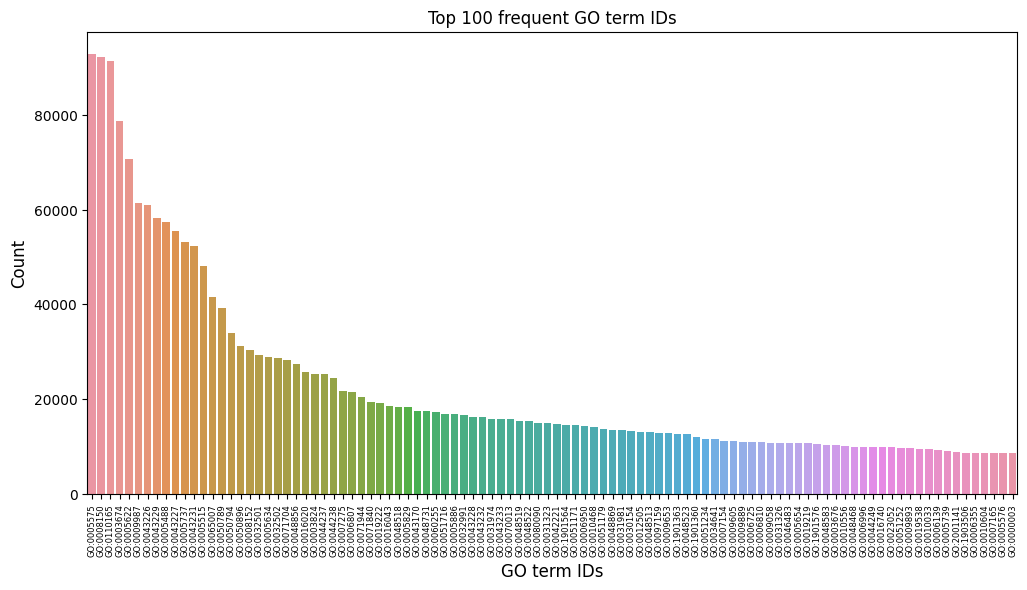

In [14]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

We will now save the first 1500 most frequent GO term Ids into a list.

In [16]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

Next, we will create a new dataframe by filtering the train terms with the selected `GO Term ID`s.

In [17]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

Let us plot the aspect values in the new **train_terms_updated** dataframe using a pie chart.

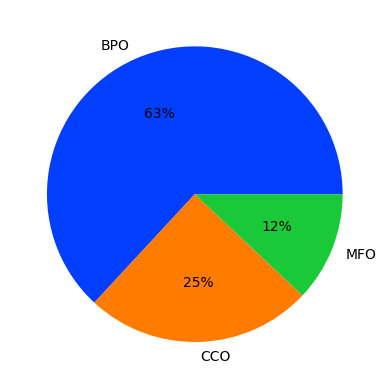

In [18]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

As you can see, majority of the `GO term Id`s have BPO(Biological Process Ontology) as their aspect.

# ***Exploratory Data Analysis***

## **Gene Ontology:** 

The ontology data is in the file go-basic.obo. This structure is the 2023-01-01 release of the GO graph. This file is in OBO format, for which there exist many parsing libraries. For example, the obonet package is available for Python. The nodes in this graph are indexed by the term name, for example the roots of the three onotlogies are:

subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}



In [19]:
# Specifying File path 
obo_file_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo"

# Reading OBO file
graph = obonet.read_obo(obo_file_path)

# Accessing the nodes and edges of the graph
graph_nodes = graph.nodes
graph_edges = graph.edges

print(f"Total number of nodes are {len(graph_nodes)} and total number of edges are {len(graph_edges)}")

Total number of nodes are 43248 and total number of edges are 84805


### **Super Terms and Sub Terms**

**Super terms**, also known as parent terms, are terms that are higher in the hierarchy and represent broader categories. They provide a way to group and organize related terms into higher-level categories. Super terms act as umbrella terms under which other lower-level categories or sub-terms are organized.

**Sub terms** (also known as child terms) are terms that are lower in the hierarchy and more specific in meaning. They represent narrower concepts that are subsets of the super terms. Sub terms provide more specific details and examples within a broader category.

- There is a hierarchical relationships between super terms and sub terms in the GO
- Hierarchy allow for organization and classification.


In [20]:
super_term_counts = {}

for node, data in graph.nodes(data=True):
    super_terms = graph.predecessors(node)
    for super_term in super_terms:
        super_term_name = graph.nodes[super_term]["name"]
        if super_term_name in super_term_counts:
            super_term_counts[super_term_name] += 1
        else:
            super_term_counts[super_term_name] = 1
            
# Sort the super term counts in descending order and select top 10
sorted_counts = sorted(super_term_counts.items(), key=lambda x: x[1], reverse=True)[:10]
pd.DataFrame(sorted_counts, columns = ['Super Term', 'Sub terms Count'])

,Super Term,Sub terms Count
0,vomitoxin biosynthetic process,11
1,viridicatumtoxin biosynthetic process,10
2,activation of prostate induction by androgen r...,9
3,negative regulation of butyryl-CoA catabolic p...,9
4,positive regulation of butyryl-CoA catabolic p...,9
5,negative regulation of respiratory burst invol...,8
6,6-sulfoquinovose(1-) catabolic process to glyc...,8
7,doxorubicin metabolic process,8
8,biotin biosynthetic process,8
9,biotin catabolic process,8


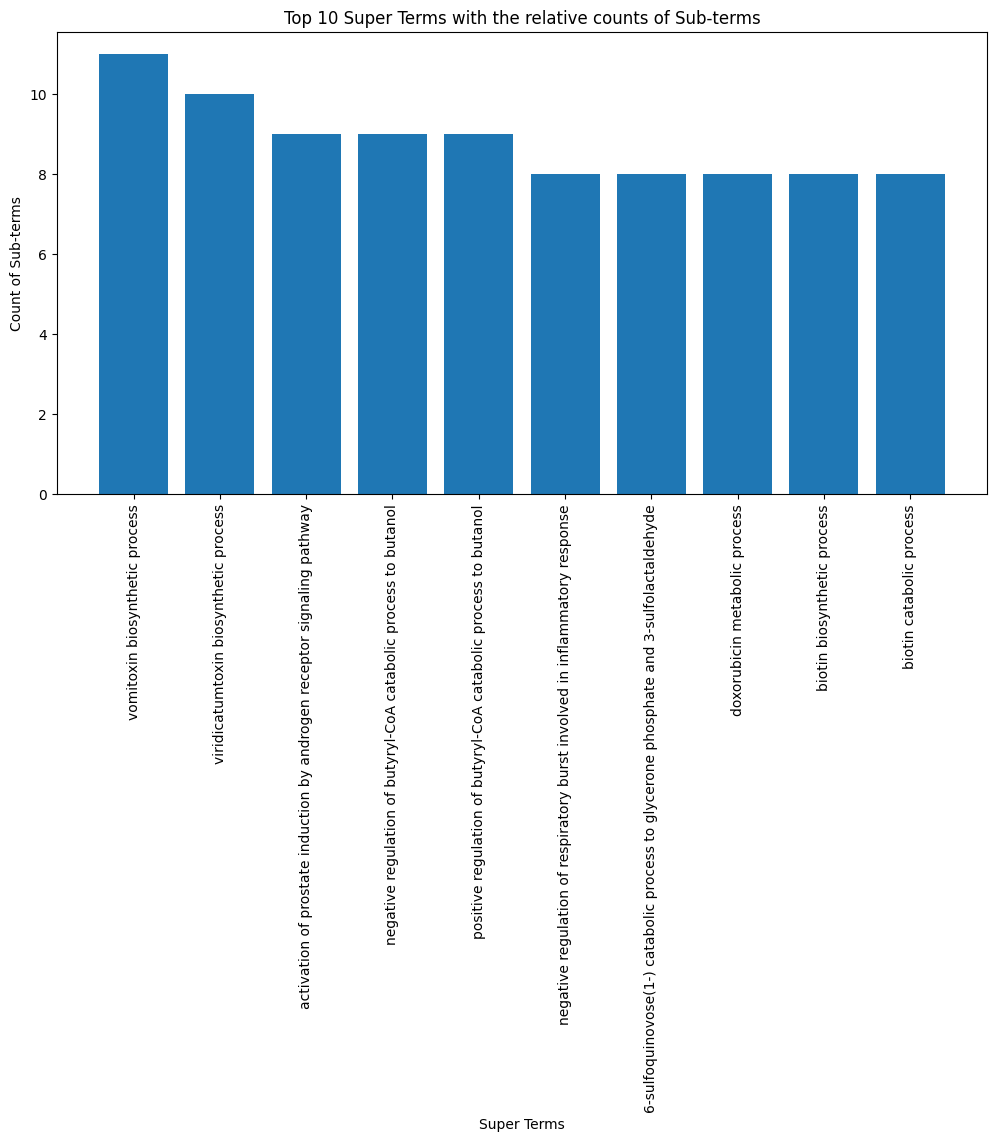

In [21]:
# Extract the super terms and counts for plotting
super_terms = [term for term, count in sorted_counts]
counts = [count for term, count in sorted_counts]

# Create the chart
plt.figure(figsize=(12, 6))
plt.bar(super_terms, counts)
plt.xlabel('Super Terms')
plt.ylabel('Count of Sub-terms')
plt.title('Top 10 Super Terms with the relative counts of Sub-terms')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The chart above provides a visual comparison of the sub-term counts across different super terms:

- The top super term with the highest count of sub-terms is "vomitoxin biosynthetic process" with 11 sub-terms. This indicates that there are 11 specific processes related to the biosynthesis of vomitoxin.

- The second super term is "viridicatumtoxin biosynthetic process" with 10 sub-terms. This suggests that there are 10 distinct processes associated with the biosynthesis of viridicatumtoxin.

- "Activation of prostate induction by androgen receptor signaling pathway" is the super term with the third-highest count of sub-terms, totaling 9. This implies that there are 9 specific processes related to the activation of prostate induction through the androgen receptor signaling pathway.

**Word clouds for super terms and sub-terms to have an idea of the distribution and frequency of terms within the ontology or taxonomy.**

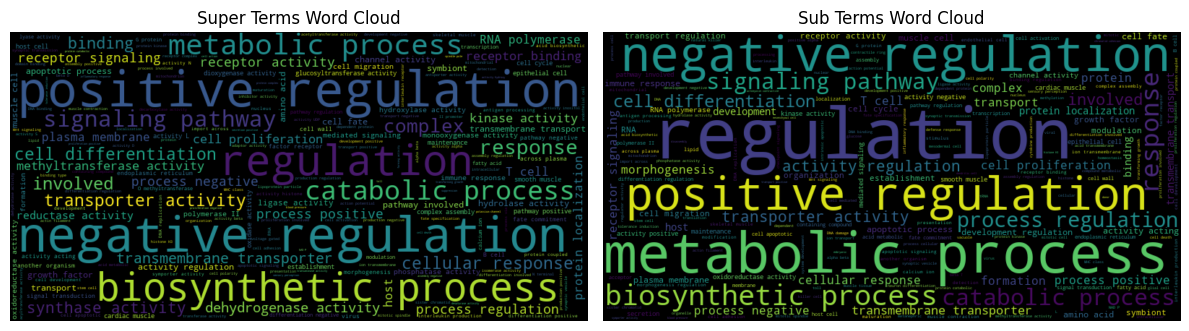

In [22]:
# Extract all super terms
super_terms = list(super_term_counts.keys())

# Collect all sub-terms
sub_terms = set()
for node in graph.nodes():
    sub_terms.update(graph.successors(node))

# Convert sub-term IDs to their corresponding names
sub_term_names = [graph.nodes[sub_term]["name"] for sub_term in sub_terms]

# Create a word cloud for super terms
super_terms_wordcloud = WordCloud(width=800, height=400).generate(' '.join(super_terms))

# Create a word cloud for sub-terms
sub_terms_wordcloud = WordCloud(width=800, height=400).generate(' '.join(sub_term_names))

# Plot the word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(super_terms_wordcloud, interpolation='bilinear')
plt.title('Super Terms Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sub_terms_wordcloud, interpolation='bilinear')
plt.title('Sub Terms Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

The super terms wordcloud visually representing the distribution and frequency of terms within the ontology or taxonomy.

Similarly, word cloud for sub-terms displaying the distribution of lower-level terms or sub-terms in the ontology or taxonomy. 

### Exploring Protein Network

Visualizing the relationships between child nodes, parent nodes, and the edges connecting them.

In [23]:

name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

go_basic_mappings_df = pd.DataFrame.from_dict(name_to_id, orient='index', columns=['Protein ID'])

go_basic_mappings_df = go_basic_mappings_df.reset_index().rename(columns={'index': 'Name'})
go_basic_mappings_df

,Name,Protein ID
0,mitochondrion inheritance,GO:0000001
1,mitochondrial genome maintenance,GO:0000002
2,reproduction,GO:0000003
3,high-affinity zinc transmembrane transporter a...,GO:0000006
4,low-affinity zinc ion transmembrane transporte...,GO:0000007
...,...,...
43243,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,GO:2001313
43244,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,GO:2001314
43245,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,GO:2001315
43246,kojic acid metabolic process,GO:2001316


In [20]:
# graph.nodes.items()

In [25]:
# Create a dictionary mapping IDs to names
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}

# Select a random node
random_node = max(name_to_id.items(), key=lambda x: x[1])[1]
print(random_node)

# Create empty lists to store the edge information
child_nodes = []
edge_keys = []
parent_nodes = []

# Find edges to parent terms
for child, parent, key in graph.out_edges(random_node, keys=True):
    child_nodes.append(id_to_name[child])
    edge_keys.append(key)
    parent_nodes.append(id_to_name[parent])

# Create a pandas dataframe from the edge information
df = pd.DataFrame({
    'Child': child_nodes,
    'Edge': edge_keys,
    'Parent': parent_nodes
})

# Print the dataframe
df

GO:2001317


,Child,Edge,Parent
0,kojic acid biosynthetic process,is_a,heterocycle biosynthetic process
1,kojic acid biosynthetic process,is_a,primary alcohol biosynthetic process
2,kojic acid biosynthetic process,is_a,ketone biosynthetic process
3,kojic acid biosynthetic process,is_a,olefinic compound biosynthetic process
4,kojic acid biosynthetic process,is_a,organic cyclic compound biosynthetic process
5,kojic acid biosynthetic process,is_a,kojic acid metabolic process


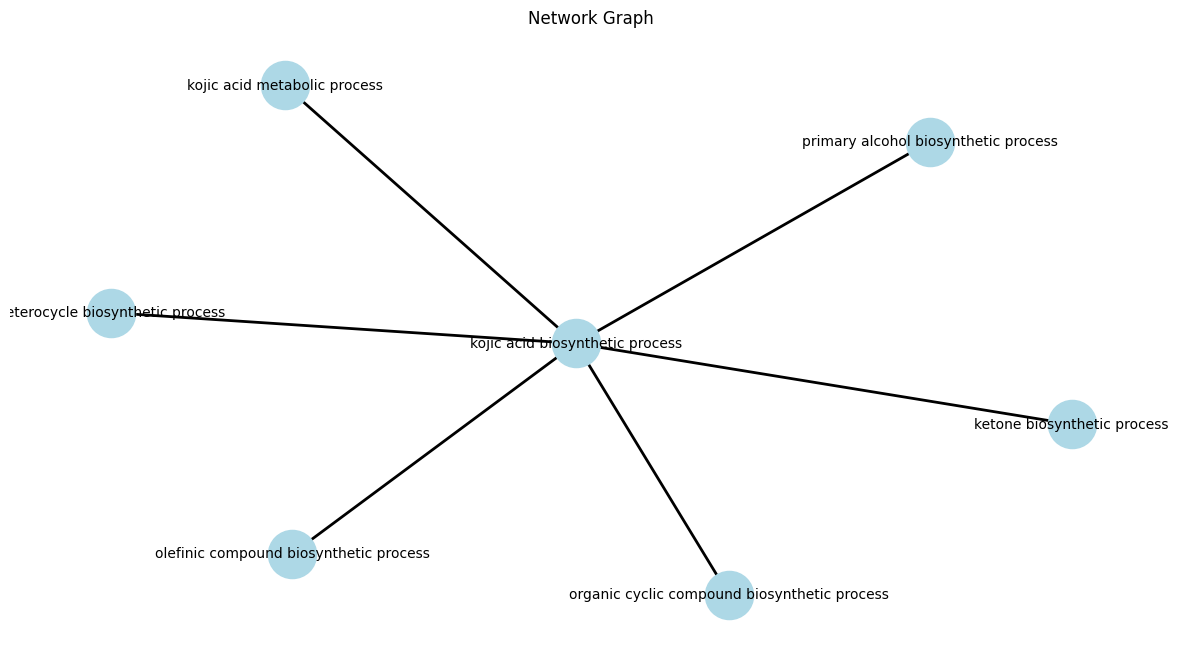

In [26]:

G = nx.from_pandas_edgelist(df, 'Child', 'Parent', create_using=nx.DiGraph())

pos = nx.spring_layout(G)

plt.figure(figsize=(15, 8))

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200)

nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, width=2.0)

nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

plt.title('Network Graph')

plt.axis('off')

plt.show()

The above graph represents the hierarchical relationships between child nodes and parent nodes. 

Each node in the graph represents a term, and the edges indicate the connections between them. 

The direction of the edges indicates the relationship from child to parent. 

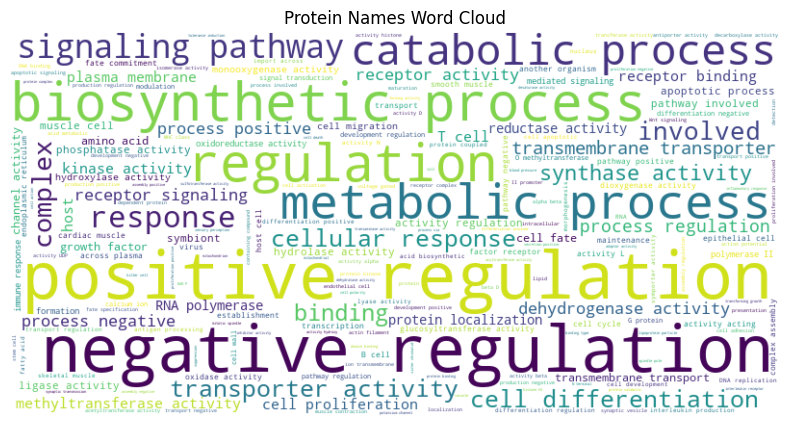

In [27]:
# Convert the dataframe to a string
text = ' '.join(go_basic_mappings_df['Name'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Protein Names Word Cloud')
plt.show()

Visual representation of the frequency of protein embedding process.

The size of each word in the cloud is determined by its frequency, with more frequent protein names appearing larger in the word cloud.

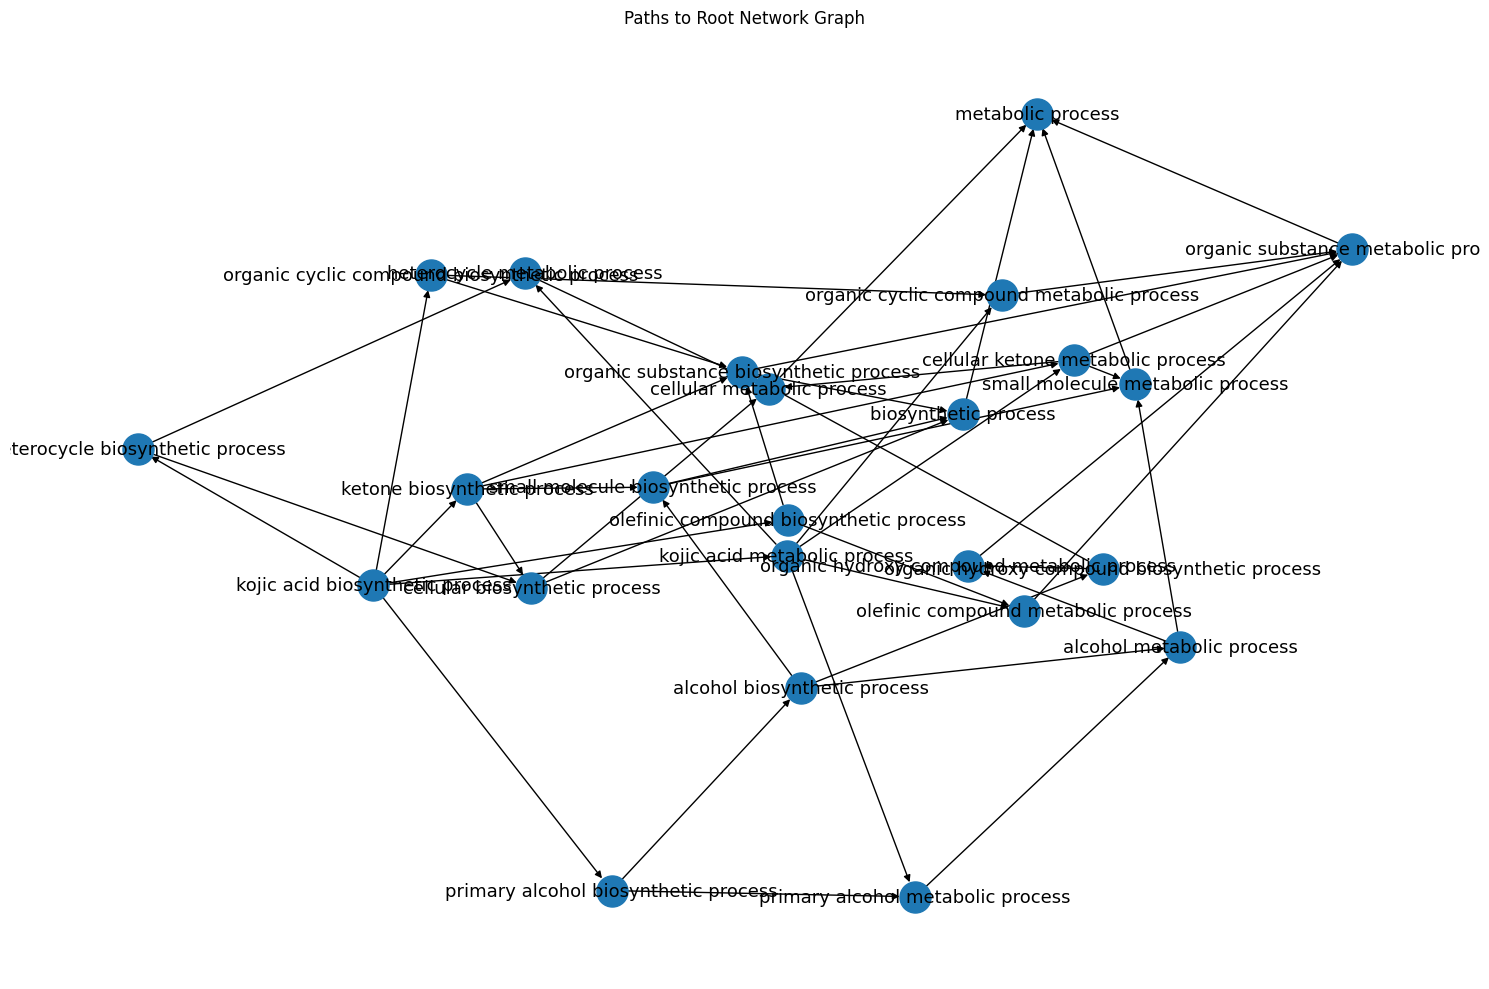

In [28]:
path_graph = nx.DiGraph()

paths = nx.all_simple_paths(
    graph,
    source=random_node,
    target=name_to_id['metabolic process'] # selecting this from above word cloud
)

for path in paths:
    for i in range(len(path) - 1):
        parent_node = path[i]
        child_node = path[i + 1]
        path_graph.add_edge(id_to_name[parent_node], id_to_name[child_node])

layout = nx.spring_layout(path_graph)

plt.figure(figsize=(15, 10))
nx.draw_networkx(path_graph, pos=layout, with_labels=True, node_size=500, font_size=13)
plt.title('Paths to Root Network Graph')
plt.axis('off')
plt.tight_layout()
plt.show()

#plt.savefig('network_graph.png', dpi=300)

#### The above graph depicts a protein network that starts from "kojic acid biosynthetic process" and finally reaching to "metabolic process"

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.
First, we will create a numpy array `train_labels` of required size for the labels. To update the `train_labels` array with the appropriate values, we will loop through the label list.

In [29]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

[========================================================================] 100%


(142246, 1500)


The final labels dataframe (`label_df`) is composed of 1500 columns and 142246 entries. We can see all 1500 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [30]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [31]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
28/28 [==============================] - 5s 101ms/step - loss: 0.1934 - binary_accuracy: 0.9426 - auc_1: 0.6867
Epoch 2/5
28/28 [==============================] - 3s 96ms/step - loss: 0.0781 - binary_accuracy: 0.9801 - auc_1: 0.8329
Epoch 3/5
28/28 [==============================] - 3s 98ms/step - loss: 0.0737 - binary_accuracy: 0.9803 - auc_1: 0.8612
Epoch 4/5
28/28 [==============================] - 3s 101ms/step - loss: 0.0700 - binary_accuracy: 0.9805 - auc_1: 0.8846
Epoch 5/5
28/28 [==============================] - 3s 96ms/step - loss: 0.0668 - binary_accuracy: 0.9807 - auc_1: 0.9025


# Plot the model's loss and accuracy for each epoch

<AxesSubplot: title={'center': 'Accuracy'}>

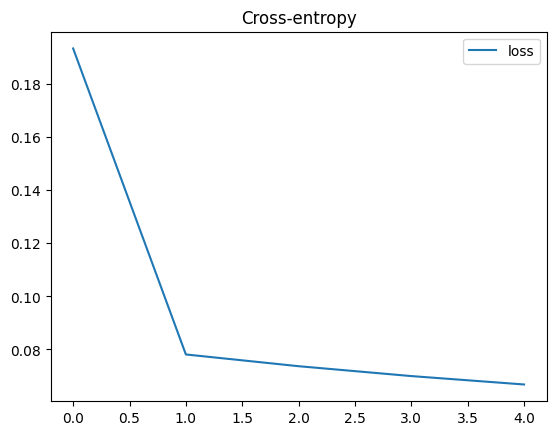

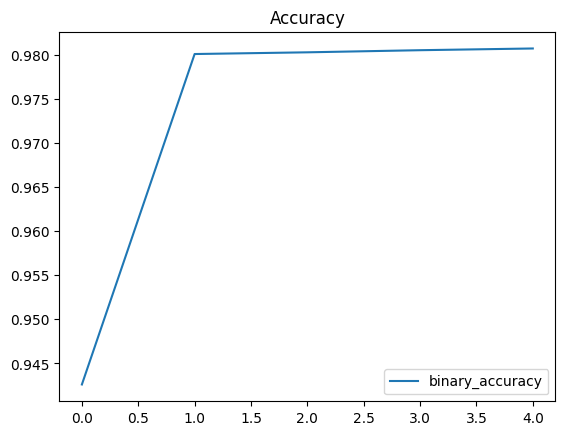

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [33]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


The `test_df` is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [34]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings. 

In [ ]:
predictions =  model.predict(test_df)

From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [ ]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [ ]:
df_submission